# Import Packages

In [24]:
# built-in
from itertools import combinations
import os

# third-party (pip install required)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from pymodulon.plotting import *
from pymodulon.util import FDR
from scipy import stats
import seaborn as sns
from tqdm.notebook import tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [11]:
K12_PATH = '../../data/k12_modulome/'
P1K_PATH = '../../data/precise1k/'
FIG_PATH = 'investigate_activities_figs'
ANNOTATION_PATH = '../../data/annotation/'

In [13]:
ica_data = load_json_model(os.path.join(K12_PATH, 'k12_modulome.json.gz'))
log_tpm_p1k = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)
log_tpm_k12 = pd.read_csv(os.path.join(K12_PATH, 'log_tpm_qc.csv'), index_col=0)
log_tpm = pd.concat([log_tpm_p1k, log_tpm_k12], axis=1, join='inner')
ica_data.log_tpm = log_tpm

# Activity Clusters

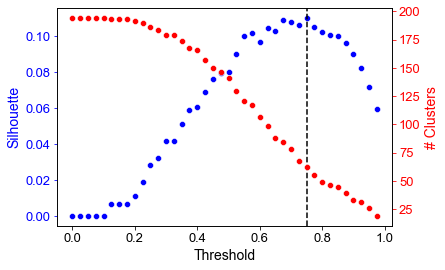

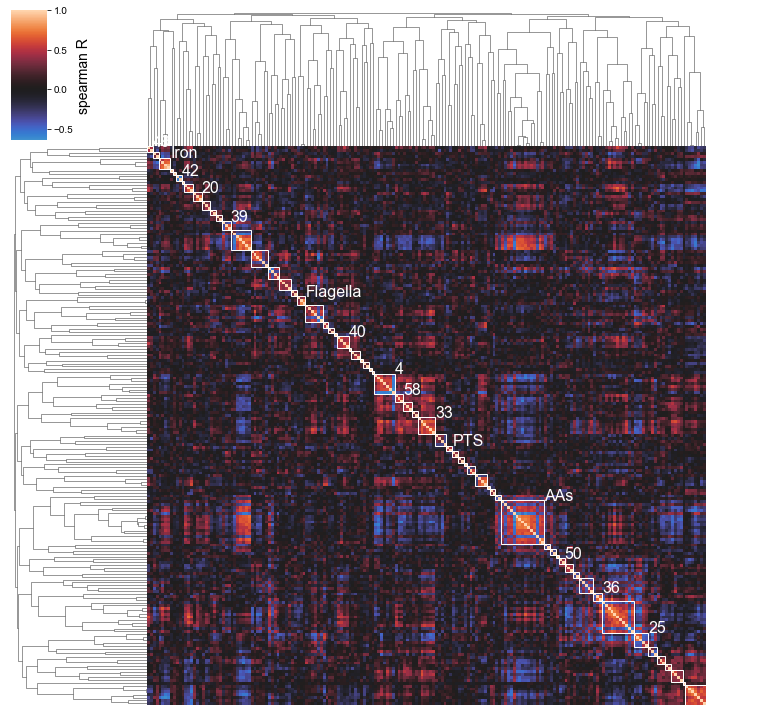

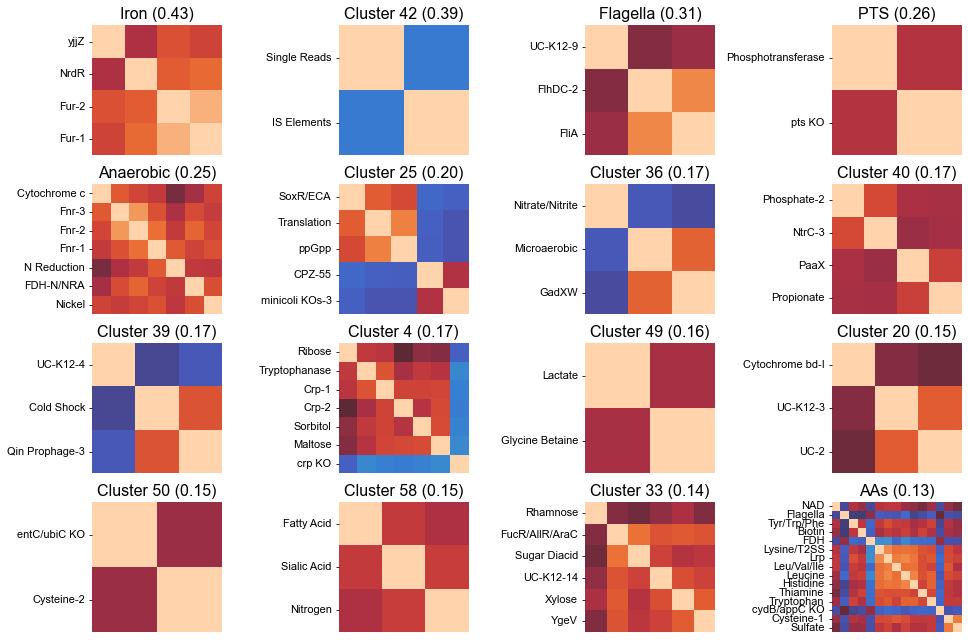

In [6]:
cluster_obj, clustermap = cluster_activities(ica_data,
    show_thresholding=True, show_best_clusters=True, n_best_clusters=16, return_clustermap=True,
    cluster_names={55: 'Iron', 37: 'Flagella', 60: 'PTS', 21: 'Anaerobic', 10: 'AAs'}
)

# CsrA

## Regulon Overlap

In [49]:
csra_regulon_genes = set(ica_data.trn[ica_data.trn['regulator'] == 'CsrA']['gene_id'])
csra_im_genes = set(ica_data.view_imodulon('CsrA').index)

csra_reg_only_names = list(ica_data.gene_table.loc[list(csra_regulon_genes - csra_im_genes), 'gene_name'])
both_names = list(ica_data.gene_table.loc[list(csra_regulon_genes.intersection(csra_im_genes)), 'gene_name'])
im_only_names = list(ica_data.gene_table.loc[list(csra_im_genes - csra_regulon_genes), 'gene_name'])

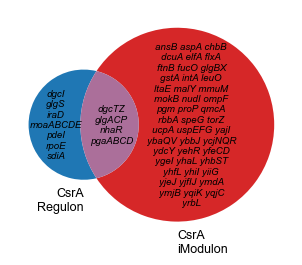

In [98]:
_, ax = plt.subplots(figsize=(4, 3))

vd_obj = venn2([csra_regulon_genes, csra_im_genes], set_labels=('CsrA\nRegulon', 'CsrA\niModulon'), set_colors=('tab:blue', 'tab:red'), alpha=1, ax=ax,
              subset_label_formatter=lambda lab: '')
[t.set_fontsize(9) for t in vd_obj.set_labels]

center_l, center_r = vd_obj.centers

def group_operons(gene_names):
    gene_group_dict = {}
    for gene_name in gene_names:
        if len(gene_name) == 3:
            gene_group_dict[gene_name] = ''
        else:
            gene_prefix = gene_name[:3]
            gene_end = gene_name[3]
            if gene_prefix in gene_group_dict:
                gene_group_dict[gene_prefix].append(gene_end)
            else:
                gene_group_dict[gene_prefix] = [gene_end]
    final_genes = []
    for gene_pre, gene_ends in gene_group_dict.items():
        final_genes.append(f"{gene_pre}{''.join(sorted(gene_ends))}")
    return final_genes
    

ax.text(center_l[0] - 0.15, center_l[1], '\n'.join(sorted(group_operons(csra_reg_only_names))), ha='center', va='center',
       fontsize=7, fontstyle='italic', font='arial')

ax.text(center_l[0] + 0.15, center_l[1], '\n'.join(sorted(group_operons(both_names))), ha='center', va='center',
       fontsize=7, fontstyle='italic', font='arial')

wid = 3
lst = sorted(group_operons(im_only_names))
final_text = '\n'.join([' '.join(lst[i-wid:i]) for i in range(wid, len(lst) + wid, wid)])
ax.text(center_r[0] + 0.075, center_r[1], final_text, ha='center', va='center',
       fontsize=7, fontstyle='italic', font='arial')

plt.savefig(os.path.join(FIG_PATH, 'csra_overlap.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'csra_overlap.png'), dpi=400, bbox_inches='tight')

## Activity

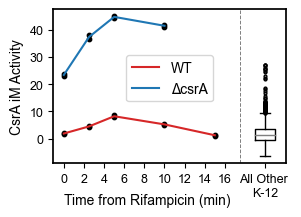

In [195]:
_, ax = plt.subplots(figsize=(3, 2))

csra_table = ica_data.sample_table[ica_data.sample_table['project'] == 'csrA']

def to_min(time_str):
    h, m, s = time_str.split(':')
    return int(m) + int(s) / 60

for col, (strain, strain_df) in zip(['tab:red', 'tab:blue'], csra_table.groupby('Strain Description')):
    
    plot_pts = []
    for time, time_df in strain_df.groupby('time'):
        time_min = to_min(time)
        a_pts = ica_data.A.loc['CsrA', time_df.index]
        plot_pts.append((time_min, a_pts.mean()))
        ax.scatter([time_min] * time_df.shape[0], a_pts, c='k', s=10)
    plot_x, plot_y = zip(*plot_pts)
    lab = 'ΔcsrA' if 'del' in strain else 'WT'
    ax.plot(plot_x, plot_y, color=col, label=lab)
    
non_csra_a = ica_data.A.loc['CsrA', ica_data.sample_table[ica_data.sample_table['project'] != 'csrA'].index]

ax.boxplot(non_csra_a, showfliers=True, medianprops={'color':'tab:gray'}, positions=[20], flierprops={'markersize': 2}, widths=[2])
        
ax.axvline(17.5, linestyle='--', linewidth=0.7, color='tab:gray')
ax.set_xlabel('', fontsize=9)
ax.text(0.045, -0.24, 'Time from Rifampicin (min)', transform=ax.transAxes, ha='left', va='center', fontsize=10)
ax.set_ylabel('CsrA iM Activity', fontsize=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_xticks(list(np.arange(0, 18, 2)) + [20])
ax.set_xticklabels(list(np.arange(0, 18, 2)) + ['All Other \nK-12'])
for s in ax.spines.values():
    s.set_linewidth(1.25)
    s.set_color('k')
ax.legend(bbox_to_anchor=(0.5, 0.55), loc='center')

plt.savefig(os.path.join(FIG_PATH, 'csra_activity.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'csra_activity.png'), dpi=400, bbox_inches='tight')

## Gene Weights

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


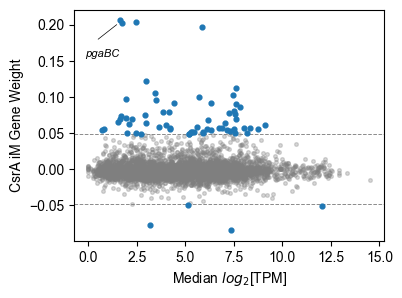

In [21]:
_, ax = plt.subplots(figsize=(4, 3))

colors = []
gene_weights = []

im_m_bin = ica_data.M_binarized['CsrA']

genes_in = list(im_m_bin[im_m_bin == 1].index)
genes_out = list(im_m_bin[im_m_bin == 0].index)

ax.scatter(log_tpm.median(axis=1).loc[genes_out], ica_data.M['CsrA'].loc[genes_out], c='tab:gray', alpha=0.3, s=7)

xy_gene = []
for gene_in in genes_in:
    x, y = log_tpm.median(axis=1).loc[gene_in], ica_data.M['CsrA'].loc[gene_in]
    ax.scatter(x, y, c='tab:blue', s=12)
    xy_gene.append(((x, y), ica_data.gene_table.loc[gene_in, 'gene_name']))
    
ax.legend(fontsize=7, framealpha=0, bbox_to_anchor=(1.01, 0.7), loc='right')
    
ax.set_xlabel('Median $log_{2}$[TPM]', fontsize=10)
ax.set_ylabel('CsrA iM Gene Weight', fontsize=10)

ax.axhline(ica_data.thresholds['CsrA'], linestyle='--', color='tab:gray', linewidth=0.7, alpha=0.9, zorder=-1)
ax.axhline(-ica_data.thresholds['CsrA'], linestyle='--', color='tab:gray', linewidth=0.7, alpha=0.9, zorder=-1)
    
# manual labeling is better honestly
# ((1.7339102441001084, 0.2026200079144597), 'pgaC'),
#  ((2.4235230163719637, 0.2031280713286817), 'pgaA'),
#  ((1.6252886880947441, 0.2062027573481212), 'pgaB')]

ax.plot((0.5, 1.45), (0.18, 0.2), linewidth=0.5, color='k')
ax.text(0.7, 0.16, 'pgaBC', ha='center', va='center', fontsize=8, fontstyle='italic', font='arial')

plt.savefig(os.path.join(FIG_PATH, 'csra_gene_weights.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'csra_gene_weights.png'), dpi=400, bbox_inches='tight')

In [18]:
sorted(xy_gene, key=lambda tup: tup[0][1])

[((7.34119918, -0.084207170828204), 'ybaQ'),
 ((3.149339687257009, -0.0774917016257907), 'ymdA'),
 ((12.059129876455733, -0.0504624336556972), 'ompF'),
 ((5.154646571163342, -0.0489248349888985), 'mokB'),
 ((5.194156919739079, 0.048644664374046), 'ybbJ'),
 ((2.710315555723846, 0.0488834695330304), 'torZ'),
 ((5.16418379812342, 0.0495172402989897), 'mmuM'),
 ((2.001061807568942, 0.0498803386453765), 'ycjQ'),
 ((8.169353972023638, 0.0501643357883734), 'ydcY'),
 ((2.464195189390632, 0.0502773484208365), 'elfA'),
 ((7.563297996673054, 0.0502936111811983), 'proP'),
 ((5.924164024521572, 0.0505091619515711), 'intA'),
 ((5.2773175315, 0.0512371314795055), 'malY'),
 ((5.319625543000001, 0.0513150152924068), 'rbbA'),
 ((5.898942321986693, 0.0517015239652813), 'qmcA'),
 ((5.421272307309179, 0.051923682136723), 'chbB'),
 ((7.271410194945337, 0.0528883238787457), 'speG'),
 ((0.6822709838428969, 0.0537281315174195), 'ymjB'),
 ((6.324759707303471, 0.0540310102975312), 'yfeC'),
 ((7.116297136841665, 